# flodym

In [1]:
import flodym as fd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## import parameters

In [2]:
params = pd.read_csv('data/params.csv')
# convert comma-delimited strings to lists
cols = ['SA params', 'Range']
for col in cols:
    str_list = [str.split(',') for str in params[col]]
    float_list = [[float(element) for element in str] for str in str_list]
    params[col] = float_list
params.head()

,Name,Default Value,Unit,Biomass,SA type,SA params,Range
0,co2c_ch4c_dig,9.00,kg CO2-C/kg CH4-C,dig,ND,"[9.0, 0.0]","[0.0, 20.0]"
1,co2c_ch4c_man,3.00,kg CO2-C/kg CH4-C,dig,ND,"[3.0, 0.0]","[0.0, 20.0]"
2,dew_c_fib,49.05,%,dig,BT,"[2.0962296131767104, 2.126062719357348, 0.0, 1...","[0.0, 100.0]"
3,dew_el,0.36,MJ/kg TWW,dig,TD,"[0.2, 0.57, 0.36]","[0.0, 5.0]"
4,dew_k_fib,10.20,%,dig,BT,"[5.090463889360777, 44.84680645722004, 0.0, 10...","[0.0, 100.0]"


In [3]:
# function to get value based on name of parameter. Can choose if monte carlo
def get_value(df, name):
    SA_type = df.loc[df['Name'] == name]['SA type'].item()
    SA_params = df.loc[df['Name'] == name]['SA params'].item()
    match SA_type:
        case 'ND':
            value = np.random.normal(*SA_params, size=monte_carlo_iterations)
        case 'LD':
            value = np.random.lognormal(*SA_params, size=monte_carlo_iterations)
        case 'TD':
            value = np.random.triangular(SA_params[0], SA_params[2], SA_params[1], size=monte_carlo_iterations)
        case 'UD':
            value = np.random.uniform(*SA_params, size=monte_carlo_iterations)
        case 'BT':
            value = np.random.beta(SA_params[0], SA_params[1], size=monte_carlo_iterations)*100
    return value

## setup definitions

In [4]:
dimension_definitions = [
    fd.DimensionDefinition(letter="s", name="substance", dtype=str),
    fd.DimensionDefinition(letter="u", name="uncertainty", dtype=str),
]

all_dims = ('s', 'u')

In [5]:
parameter_definitions = [
    # fd.ParameterDefinition(name="dewatering share to fibers", dim_letters=all_dims),
    # fd.ParameterDefinition(name="manure composition", dim_letters=('s',)),
]

In [6]:
process_names = [
    "sysenv",
    "dewatering",
    "storage"
]

In [7]:
flow_definitions = [
    fd.FlowDefinition(from_process_name="sysenv", to_process_name="dewatering", dim_letters=all_dims),
    fd.FlowDefinition(from_process_name="dewatering", to_process_name="storage", dim_letters=all_dims),
    fd.FlowDefinition(from_process_name="dewatering", to_process_name="sysenv", dim_letters=all_dims),
    fd.FlowDefinition(from_process_name="storage", to_process_name="sysenv", dim_letters=all_dims),
]

In [8]:
# flodym needs a stock, so we create a dummy
stock_definitions = [
    fd.StockDefinition(
        name="dummy",
        dim_letters=all_dims,
        time_letter='s',
        subclass=fd.SimpleFlowDrivenStock,
    ),
]

In [9]:
mfa_definition = fd.MFADefinition(
    dimensions=dimension_definitions,
    parameters=parameter_definitions,
    processes=process_names,
    flows=flow_definitions,
    stocks=stock_definitions,
)

## data sources

In [10]:
monte_carlo_iterations = 100
monte_carlo_idxs = list(range(monte_carlo_iterations))
df = pd.DataFrame(monte_carlo_idxs)
df.to_csv('data/dimension_uncertainty.csv', index=False, header=False)

In [11]:
dimension_files = {
    "substance": "data/dimension_substance.csv",
    "uncertainty": "data/dimension_uncertainty.csv",
}

In [12]:
parameter_files = {
    # "dewatering share to fibers": "data/parameter_dewatering_share_to_fibers.csv",
    # "manure composition": "data/parameter_manure.csv",
}

# file contents as format example
print(open("data/parameter_manure.csv", "r").read())

substance, value
dry matter,0.1
water,0.9


## compute routine

In [13]:
class SimpleMFA(fd.MFASystem):
    
    def compute(self):

        # cast_to() broadcasts manure composition which is only defined with substances (not uncertainty)
        # to all dimensions in the dimension set of the SimpleMFA object
        self.flows["sysenv => dewatering"][...] = self.parameters["manure composition"].cast_to(self.dims)
        self.flows["dewatering => sysenv"][...] = self.flows["sysenv => dewatering"] * self.parameters["dewatering share to fibers"]
        self.flows['dewatering => storage'][...] = self.flows['sysenv => dewatering'] * (1 - self.parameters["dewatering share to fibers"])
        self.flows['storage => sysenv'][...] = self.flows['dewatering => storage']

        '''
        # use stock
        self.stocks["use"].inflow[...] = self.flows["manufacturing => use"][...]
        self.stocks["use"].lifetime_model.set_prms(
            mean=self.parameters["product lifetimes"],
            std=0.5*self.parameters["product lifetimes"],
        )
        self.stocks["use"].compute()
        
        # end-of-life  flow
        self.flows["use => sysenv"][...] = self.stocks["use"].outflow
        ''';

## Init, load & compute

In [14]:
mfa_example = SimpleMFA.from_csv(
    definition=mfa_definition,
    dimension_files=dimension_files,
    parameter_files=parameter_files,
)

In [15]:
tww = np.ones(monte_carlo_iterations)
ts = get_value(params, 'man_ts')
w = tww - ts

tww_fib = tww * get_value(params, 'dew_tww_fib')/100
ts_fib = ts * get_value(params, 'dew_ts_fib')/100
w_fib = tww_fib - ts_fib

w_share_fib = w_fib/w

dewatering_shares = np.array([
    get_value(params, 'dew_ts_fib')/100,
    w_share_fib,
])

In [16]:
mfa_example.parameters["dewatering share to fibers"] = fd.Parameter(
    name="dewatering share to fibers",
    dims=mfa_example.dims,
    values=dewatering_shares
)

In [17]:
manure_composition = np.array([
    get_value(params, 'man_ts'),
    1-get_value(params, 'man_ts'),
])

In [18]:
mfa_example.parameters["manure composition"] = fd.Parameter(
    name="manure composition",
    dims=mfa_example.dims,
    values=manure_composition
)

In [19]:
mfa_example.compute() 

In [20]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

mfa_example.check_mass_balance()

INFO:root:Checking mass balance of SimpleMFA object...
INFO:root:Success - Mass balance is consistent!


In [21]:
def get_mfa_value(flow: str, substance: str):
    return mfa_example.flows[flow][substance].values

In [108]:
mfa_example.flows['sysenv => dewatering']['dry matter'].values

array([0.05723279, 0.03708832, 0.05731357, 0.06640485, 0.07329215,
       0.07334918, 0.04964151, 0.07415573, 0.06368134, 0.04665188,
       0.03147193, 0.08319355, 0.05095395, 0.05648404, 0.0568074 ,
       0.13215664, 0.04445444, 0.04639505, 0.04767809, 0.05025125,
       0.05828512, 0.10539445, 0.05838802, 0.06270942, 0.0826503 ,
       0.06429448, 0.05292458, 0.09343731, 0.07046284, 0.08073376,
       0.07754713, 0.08773938, 0.07895343, 0.07120966, 0.08624697,
       0.05595797, 0.0644608 , 0.05210824, 0.11149091, 0.08769287,
       0.06853881, 0.09392283, 0.08890437, 0.07847584, 0.08531711,
       0.09047529, 0.06185793, 0.04675786, 0.03581836, 0.08013628,
       0.07392744, 0.0842706 , 0.0791239 , 0.07216645, 0.07556745,
       0.06955715, 0.06517709, 0.04150837, 0.06831299, 0.10268038,
       0.05144681, 0.07858515, 0.11266128, 0.05359275, 0.05637938,
       0.0730723 , 0.09220202, 0.07102534, 0.04625625, 0.07616526,
       0.06935585, 0.06024009, 0.07217311, 0.07436541, 0.06505

## Sankey Plotting

In [22]:
i = iter(range(monte_carlo_iterations))

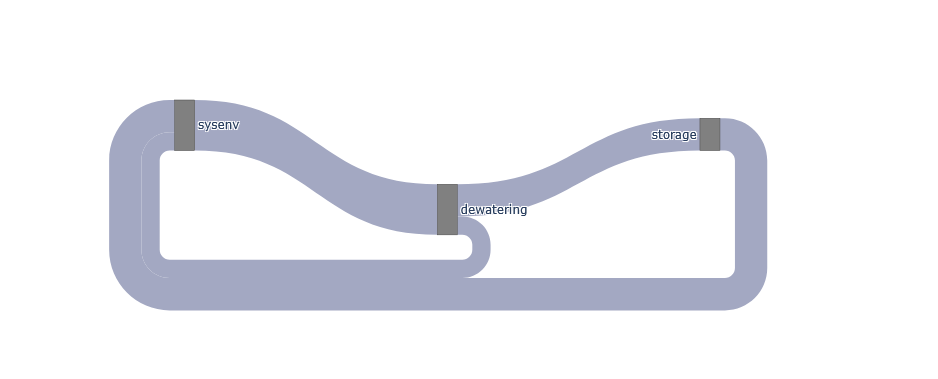

In [107]:
# Plot MFA result with sankey. Every time this cell is run,
# the result of a new monte carlo iteration is shown
import flodym.export as fde
fig = fde.PlotlySankeyPlotter(mfa=mfa_example, exclude_processes=[], slice_dict={'u': str(next(i))}).plot()
fig.show()

In [24]:
# example of looking at the value of a flow. Now it is a list of all the monte carlo iteration results
mfa_example.flows['dewatering => storage']['dry matter'].values[:5]

array([0.04479887, 0.02660964, 0.03156616, 0.01203833, 0.03339448])

# Brightway implementation

In [53]:
import bw2data as bd
import bw2io as bi
import bw2calc as bc

## setup project and databases

In [54]:
bd.projects

Brightway2 projects manager with 9 objects:
	Another one bikes the dust
	Another project
	Bicycle example
	USEEIO-1.1
	default
	ecoinvent-3.11-cutoff-bw25
	ecoinvent-3.12-cutoff
	electric_vehicle_standalone
	manure
Use `projects.report()` to get a report on all projects.

In [55]:
if 'manure' in bd.projects:
    bd.projects.delete_project(name='manure', delete_dir=True)
bd.projects.set_current('ecoinvent-3.11-cutoff-bw25')
bd.projects.copy_project('manure', switch=True)
if 'lci-pass_cars' in bd.databases:
    del bd.databases['lci-pass_cars']

In [56]:
def create_bw_db(name : str):
    if name in bd.databases:
        del bd.databases[name]    
    db = bd.Database(name)
    db.register()
    return db

In [109]:
db = create_bw_db('manure')

## manual LCA setup

In [110]:
ecoinvent_el = get_mfa_value('sysenv => dewatering', 'dry matter').mean()
storage_dm = get_mfa_value('dewatering => storage', 'dry matter').mean()

In [111]:
# nodes
manure_management = db.new_node(
    name='manure management',
    unit='ton',
    type=bd.labels.product_node_default,
)
manure_management.save()

manure_management_process = db.new_node(
    name='manure management process',
    location='DK',
    type=bd.labels.process_node_default,
)
manure_management_process.save()

electricity = db.new_node(
    name='electricity',
    unit='kWh',
    location='DK',
    type=bd.labels.product_node_default,
)
electricity.save()

dewatering_electricity = db.new_node(
    name='dewatering electricity',
    location='DK',
    type=bd.labels.process_node_default,
)
dewatering_electricity.save()

methane = db.new_node(
    name='methane',
    unit='kg',
    type=bd.labels.product_node_default,
)
methane.save()

storage_methane = db.new_node(
    name='storage methane',
    location='DK',
    type=bd.labels.process_node_default,
)
storage_methane.save()

In [112]:
ei_electricity = bd.get_node(
    database='ecoinvent-3.11-cutoff',
    name='market for electricity, medium voltage',
    location='DK',
)

bs_methane = bd.get_node(
    database='ecoinvent-3.11-biosphere',
    name='Methane, non-fossil',
    categories=('air',)        
)

In [113]:
manure_management_process.new_edge(
    amount=1,
    input=manure_management,
    type=bd.labels.production_edge_default,
).save()

manure_management_process.new_edge(
    amount=1,
    input=electricity,
    type=bd.labels.consumption_edge_default,
).save()

manure_management_process.new_edge(
    amount=1,
    input=methane,
    type=bd.labels.consumption_edge_default,
).save()

dewatering_electricity.new_edge(
    amount=1,
    input=electricity,
    type=bd.labels.production_edge_default
).save()

dewatering_electricity.new_edge(
    amount=get_mfa_value('sysenv => dewatering', 'dry matter').mean()/5,
    input=ei_electricity,
    type=bd.labels.consumption_edge_default,
).save()

storage_methane.new_edge(
    amount=1,
    input=methane,
    type=bd.labels.production_edge_default,
).save()

storage_methane.new_edge(
    amount=get_mfa_value('dewatering => storage', 'dry matter').mean()/1000,
    input=bs_methane,
    type=bd.labels.biosphere_edge_default,
).save()

### simple LCIA

In [114]:
my_method = bd.Method(
    ('ecoinvent-3.11', 
     'CML v4.8 2016', 
     'climate change', 
     'global warming potential (GWP100)')
)
my_method.name

('ecoinvent-3.11',
 'CML v4.8 2016',
 'climate change',
 'global warming potential (GWP100)')

In [115]:
def calc_lca(functional_unit_product, amount : float, method):
    functional_unit, data_objs, _ = bd.prepare_lca_inputs(
        demand={functional_unit_product: amount},
        method=method.name,
    )
        
    my_lca = bc.LCA(demand=functional_unit, data_objs=data_objs)
    
    return my_lca

In [116]:
my_lca = calc_lca(manure_management, 1, my_method)

my_lca.lci()
my_lca.lcia()
my_lca.score

INFO:bw2calc:Initialized LCA object. Demand: {247442650066501632: 1}, data_objs: [<bw_processing.datapackage.Datapackage object at 0x7060b9504590>, <bw_processing.datapackage.Datapackage object at 0x7060b98e2810>, <bw_processing.datapackage.Datapackage object at 0x7060c4fb1fd0>, <bw_processing.datapackage.Datapackage object at 0x7060c527f4a0>]


0.0036051272945098953

### contribution analysis

In [117]:
# get all product nodes from our foreground system for contribution analysis
foreground_products = [node for node in db if node['type'] == bd.labels.product_node_default]
foreground_products

['methane' (kg, GLO, None),
 'electricity' (kWh, DK, None),
 'manure management' (ton, GLO, None)]

In [118]:
my_lca = calc_lca(manure_management, 1, my_method)
my_lca.lci()

product_scores = {}
# loop over all product nodes in the foreground system (eventually: also all LCIA methods)
for product in foreground_products:
    my_lca.lcia(demand={product.id: 1})
    product_scores[product['name']] = my_lca.score

INFO:bw2calc:Initialized LCA object. Demand: {247442650066501632: 1}, data_objs: [<bw_processing.datapackage.Datapackage object at 0x7060b9505970>, <bw_processing.datapackage.Datapackage object at 0x7060b9507380>, <bw_processing.datapackage.Datapackage object at 0x7060b9507920>, <bw_processing.datapackage.Datapackage object at 0x7060b9504980>]


In [119]:
product_scores

{'methane': 0.0010649980104062706,
 'electricity': 0.0025401292841036247,
 'manure management': 0.0036051272945098953}

## automatic LCA setup

### setup database

In [120]:
db = create_bw_db('manure')

In [121]:
manure_dm = get_mfa_value('sysenv => dewatering', 'dry matter')
storage_dm = get_mfa_value('dewatering => storage', 'dry matter')

monte_carlo_list = []
for idx in monte_carlo_idxs:
    list_of_things_in_mfa_with_impact = [
        {
            'name': 'storage methane',
            'unit': 'kg',
            'amount': storage_dm[idx] * get_value(params, 'ch4_ef_dig')[idx] / 1000,
            'background_database_id': {
                'database': 'ecoinvent-3.11-biosphere',
                'name': 'Methane, non-fossil',
                'categories': ('air',),
                'code': 'da1157e2-7593-4dfd-80dd-a3449b37a4d8',
            }
        },
        {
            'name': 'dewatering electricity',
            'unit': 'kWh',
            'amount': manure_dm[idx] / 5,
            'background_database_id': {
                'database': 'ecoinvent-3.11-cutoff',
                'name': 'market for electricity, medium voltage',
                'code': '6bcbd7fc891c8b3bf0dd96027c1f9b0e',
            }
        },
    ]

    monte_carlo_list.append(list_of_things_in_mfa_with_impact)

In [122]:
def fill_database_with_list_of_things_with_impact(db, list_of_things_with_impact):
    # args: database to fill with things, list of dicts with information about things with impact
    # dicts in list could look like this:
        #    {
        #    'name': 'steel',
        #    'unit': 'kg',
        #    'amount': get_mfa_value('sysenv => dewatering', 'dry matter'),
        #    'background_database_id': {
        #       'database': 'ecoinvent-3.11-cutoff',
        #        'name': 'market for steel, low-alloyed',
        #        'code': '93c303c0802e644199a4cd6033095811',
        #        }
        #    },
    
    functional_unit_process = db.new_node(
        name='functional_unit_process',
        code='functional_unit_process',
        type=bd.labels.process_node_default,
    )
    functional_unit_process.save()
    
    functional_unit_product = db.new_node(
        name='functional_unit_product',
        code='functional_unit_product',
        unit='kg',
        type=bd.labels.product_node_default,
    )
    functional_unit_product.save()
    
    functional_unit_edge = functional_unit_process.new_edge(
            amount=1,
            input=functional_unit_product,
            type=bd.labels.production_edge_default,    
    )
    functional_unit_edge.save()  
    
    for thing in list_of_things_with_impact:
        product = db.new_node(
            name=thing['name'],
            code=thing['name'],
            type=bd.labels.product_node_default,
        )
        product.save()
        
        process = db.new_node(
            name=f'{thing['name']}_process',
            code=f'{thing['name']}_process',
            unit=thing['unit'],
            type=bd.labels.process_node_default,
        )
        process.save()
    
        edge = process.new_edge(
            amount=1,
            input=product,
            type=bd.labels.production_edge_default,
        )
        edge.save()
    
        edge = functional_unit_process.new_edge(
            amount=1,
            input=product,
            type=bd.labels.consumption_edge_default,
        )
        edge.save()
    
        if thing['background_database_id']['database'] == 'ecoinvent-3.11-biosphere':
            biosphere_flow = bd.get_node(
                database='ecoinvent-3.11-biosphere',
                code=thing['background_database_id']['code'],
            )
           
            edge = process.new_edge(
                database='ecoinvent-3.11-biosphere',
                name=thing['background_database_id']['name'],
                categories=thing['background_database_id']['categories'],
                amount=thing['amount'],
                input=biosphere_flow,
                type=bd.labels.biosphere_edge_default,
            )
            edge.save()
            
        elif thing['background_database_id']['database'] == 'ecoinvent-3.11-cutoff':
            ecoinvent_product = bd.get_node(
                database='ecoinvent-3.11-cutoff',
                code=thing['background_database_id']['code'],
            )
           
            edge = process.new_edge(
                database='ecoinvent-3.11-biosphere',
                name=thing['background_database_id']['name'],
                amount=thing['amount'],
                input=ecoinvent_product,
                type=bd.labels.consumption_edge_default,
            )
            edge.save()
        else:
            print('Ecoinvent database not found. Check database name.')

### simple LCA

In [123]:
monte_carlo_scores = []
for sample in monte_carlo_list:
    db = create_bw_db('manure')
    fill_database_with_list_of_things_with_impact(db, sample)
    db.process()
    
    functional_unit_product = bd.get_node(
        name='functional_unit_product',
        database='manure',
    )
    
    my_lca = calc_lca(functional_unit_product, 1, my_method)
    my_lca.lci()
    my_lca.lcia()
    score = my_lca.score
    
    monte_carlo_scores.append(score)

INFO:bw2calc:Initialized LCA object. Demand: {247442720623083520: 1}, data_objs: [<bw_processing.datapackage.Datapackage object at 0x7060b950f4d0>, <bw_processing.datapackage.Datapackage object at 0x7060b950d9a0>, <bw_processing.datapackage.Datapackage object at 0x7060b950e000>, <bw_processing.datapackage.Datapackage object at 0x7060b924b230>]
INFO:bw2calc:Initialized LCA object. Demand: {247442722380496896: 1}, data_objs: [<bw_processing.datapackage.Datapackage object at 0x7060c4e74260>, <bw_processing.datapackage.Datapackage object at 0x705faa05ab70>, <bw_processing.datapackage.Datapackage object at 0x7060b957a990>, <bw_processing.datapackage.Datapackage object at 0x7060b969c2f0>]
INFO:bw2calc:Initialized LCA object. Demand: {247442724192436224: 1}, data_objs: [<bw_processing.datapackage.Datapackage object at 0x7060b924bef0>, <bw_processing.datapackage.Datapackage object at 0x705f9f749430>, <bw_processing.datapackage.Datapackage object at 0x7060c55ddac0>, <bw_processing.datapackage.D

Text(0, 0.5, 'probability density')

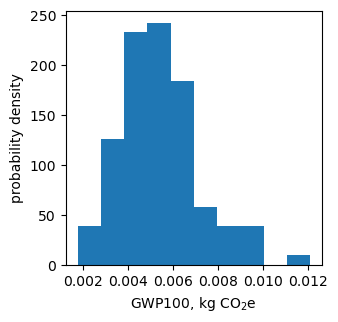

In [124]:
plt.figure(figsize=(3.3,3.3))
plt.hist(monte_carlo_scores, density=True)
plt.xlabel('GWP100, kg CO$_2$e')
plt.ylabel('probability density')

### contribution analysis

In [125]:
foreground_products = [node for node in db if node['type'] == bd.labels.product_node_default]
product_scores = {product['name']: [] for product in foreground_products}
foreground_products

['storage methane' (None, GLO, None),
 'dewatering electricity' (None, GLO, None),
 'functional_unit_product' (kg, GLO, None)]

In [126]:
for sample in monte_carlo_list[:10]:
    db = create_bw_db('manure')
    fill_database_with_list_of_things_with_impact(db, sample)
    db.process()
    
    functional_unit_product = bd.get_node(
        name='functional_unit_product',
        database='manure',
    )
    
    my_lca = calc_lca(functional_unit_product, 1, my_method)
    my_lca.lci()

    foreground_products = [node for node in db if node['type'] == bd.labels.product_node_default]

    # loop over all product nodes in the foreground system (eventually: also all LCIA methods)
    for product in foreground_products:
        my_lca.lcia(demand={product.id: 1})
        product_scores[product['name']].append(my_lca.score)
        

INFO:bw2calc:Initialized LCA object. Demand: {247442946335358976: 1}, data_objs: [<bw_processing.datapackage.Datapackage object at 0x7060b9505970>, <bw_processing.datapackage.Datapackage object at 0x705f9e6bbc80>, <bw_processing.datapackage.Datapackage object at 0x7060c6528650>, <bw_processing.datapackage.Datapackage object at 0x7060c4eda6c0>]
INFO:bw2calc:Initialized LCA object. Demand: {247442948189241344: 1}, data_objs: [<bw_processing.datapackage.Datapackage object at 0x7060c54c17c0>, <bw_processing.datapackage.Datapackage object at 0x7060c52be8a0>, <bw_processing.datapackage.Datapackage object at 0x7060c5306cf0>, <bw_processing.datapackage.Datapackage object at 0x7060c523d880>]
INFO:bw2calc:Initialized LCA object. Demand: {247442950097649664: 1}, data_objs: [<bw_processing.datapackage.Datapackage object at 0x7060b96006e0>, <bw_processing.datapackage.Datapackage object at 0x7060b9602f60>, <bw_processing.datapackage.Datapackage object at 0x7060b98e3920>, <bw_processing.datapackage.D

In [127]:
df = pd.DataFrame(product_scores)
df_mean = pd.DataFrame(df.mean()).T
df_mean.drop(columns='functional_unit_product', inplace=True)
df_mean.index = ['manure management']
df_mean

,storage methane,dewatering electricity
manure management,0.002177,0.002136


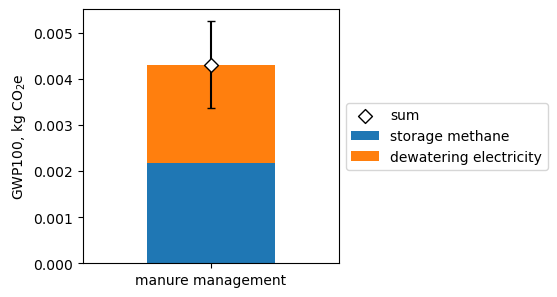

In [128]:
fig, ax = plt.subplots(figsize=(3.3,3.3))
df_mean.plot.bar(stacked=True, ax=ax, zorder=-1)

mean = std = df['functional_unit_product'].mean()
std = df['functional_unit_product'].std()

ax.errorbar(0, mean, yerr=std, c='k', capsize=3, zorder=0)
ax.scatter(0, mean, s=50, marker='D', c='white', edgecolor='k', label='sum', zorder=1)

ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
ax.set_ylabel('GWP100, kg CO$_2$e')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
fig.show()

Text(0.5, 0, 'GWP100, kg CO$_2$e')

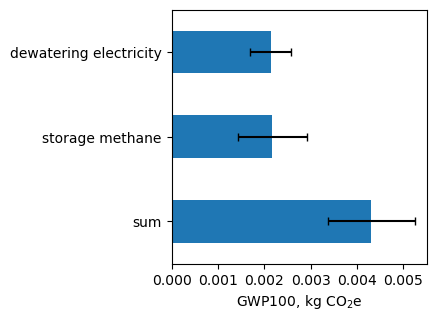

In [129]:
stats_df = pd.DataFrame({
    'mean': df.mean(),
    'std': df.std()
}).sort_values('mean', ascending=False)

stats_df.index = ['sum'] + list(stats_df.index[1:])

fig, ax = plt.subplots(figsize=(3.3,3.3))

# bar plot
stats_df['mean'].plot.barh(ax=ax, legend=False)

# properly aligned error bars
x = np.arange(len(stats_df))
ax.errorbar(
    stats_df['mean'], x, xerr=stats_df['std'],
    fmt='none', c='k', capsize=3
)

ax.set_xlabel('GWP100, kg CO$_2$e')
